In [1]:
import anndata as ad
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import umap
import scipy as sp
import seaborn as sns

In [2]:
from dynchro.tl import dtw, traceback
from collections import defaultdict

# 1. Preprocess data

In [6]:
d1 = ad.read_h5ad("data/dataseta2.h5ad")
d2 = ad.read_h5ad("data/datasetb2.h5ad")
d1, d2

(AnnData object with n_obs × n_vars = 5000 × 522
     obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones'
     var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein'
     uns: 'iroot', 'traj_dimred_segments', 'traj_milestone_network', 'traj_progressions'
     obsm: 'dimred'
     layers: 'counts_protein', 'counts_spliced', 'counts_unspliced', 'logcounts',
 AnnData object with n_obs × n_vars = 5000 × 522
     obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones'
     var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mr

In [7]:
# d1.uns["iroot"] = np.flatnonzero(d1.obs_names == d1.uns["iroot"])[0]
# d2.uns["iroot"] = np.flatnonzero(d2.obs_names == d2.uns["iroot"])[0]
d1.uns["iroot"] = np.flatnonzero(d1.obs["sim_time"] == 0.0)[5]
d2.uns["iroot"] = np.flatnonzero(d2.obs["sim_time"] == 0.0)[5]

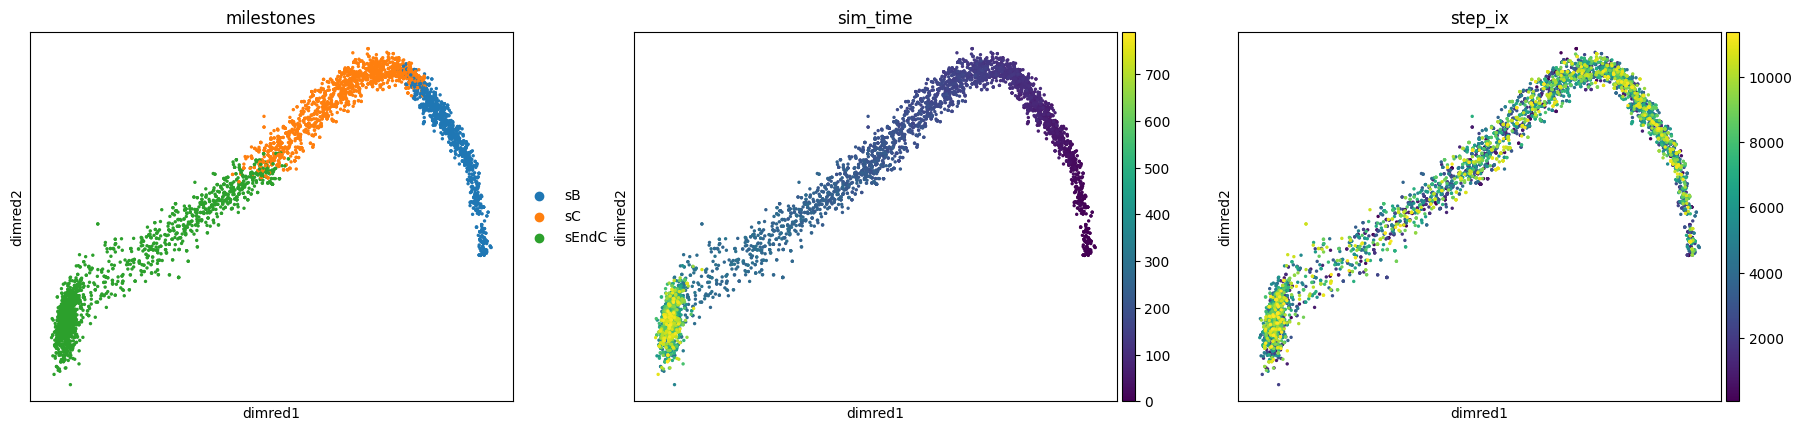

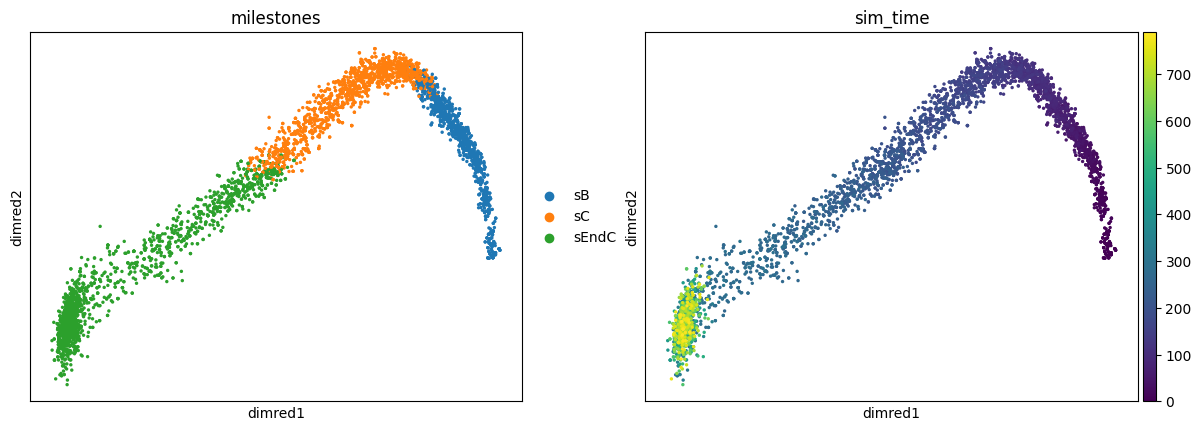

In [8]:
# d1.obsm["X_dimred"]
sc.pl.embedding(d1, basis = "dimred", color = ["milestones", "sim_time", "step_ix"])
sc.pl.embedding(d2, basis = "dimred", color = ["milestones", "sim_time"])

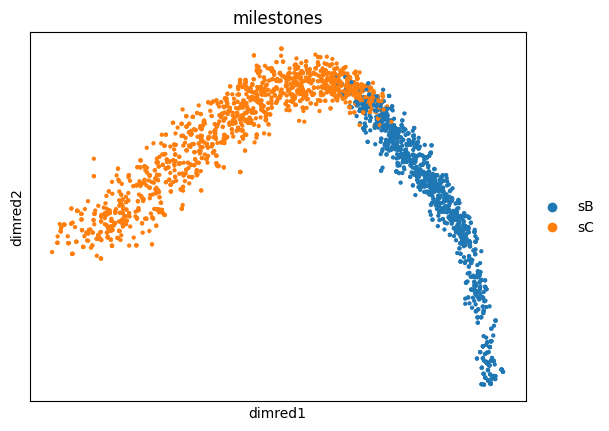

In [9]:
# remove sEndC from d2
d2 = d2[d2.obs["milestones"] != "sEndC", :]
sc.pl.embedding(d2, basis = "dimred", color = "milestones")

In [10]:
def preprocess(dataset):
    sc.pp.normalize_total(dataset, target_sum=1e4)
    sc.pp.log1p(dataset)
    sc.pp.pca(dataset)
    sc.pp.neighbors(dataset, n_neighbors=15)
    sc.tl.umap(dataset)
    sc.tl.leiden(dataset)
    return dataset

In [11]:
d1 = preprocess(d1)
d2 = preprocess(d2)

/tmp/ipykernel_54886/683822307.py:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(dataset)
/home/louise/Work/dynchro_paper/.venv/lib/python3.13/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [12]:
sc.tl.diffmap(d1)
sc.tl.diffmap(d2)

sc.tl.dpt(d1, n_dcs=10)
sc.tl.dpt(d2, n_dcs=10)
d1.obs["pseudotime"] = d1.obs["dpt_pseudotime"]
d2.obs["pseudotime"] = d2.obs["dpt_pseudotime"]

d1, d2

(AnnData object with n_obs × n_vars = 5000 × 522
     obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'pseudotime'
     var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein'
     uns: 'iroot', 'traj_dimred_segments', 'traj_milestone_network', 'traj_progressions', 'milestones_colors', 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'diffmap_evals'
     obsm: 'dimred', 'X_pca', 'X_umap', 'X_diffmap'
     varm: 'PCs'
     layers: 'counts_protein', 'counts_spliced', 'counts_unspliced', 'logcounts'
     obsp: 'distances', 'connectivities',
 AnnData object with n_obs × n_vars = 3132 × 522
     obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'pseudotime'
     var: 'module_id', 'b

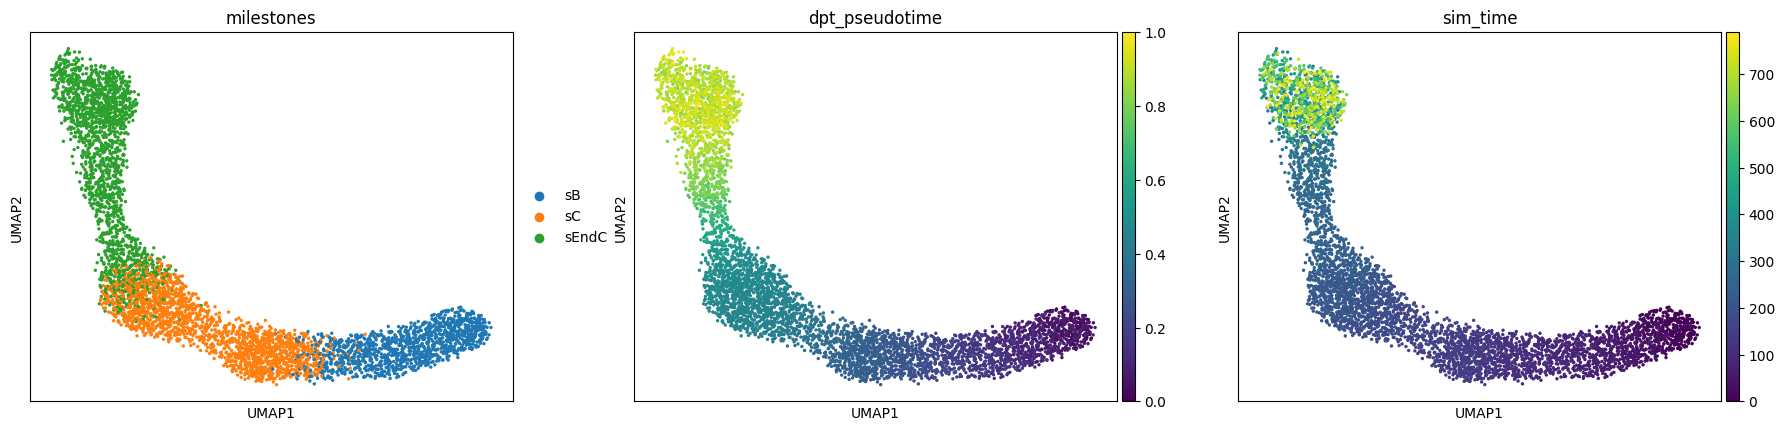

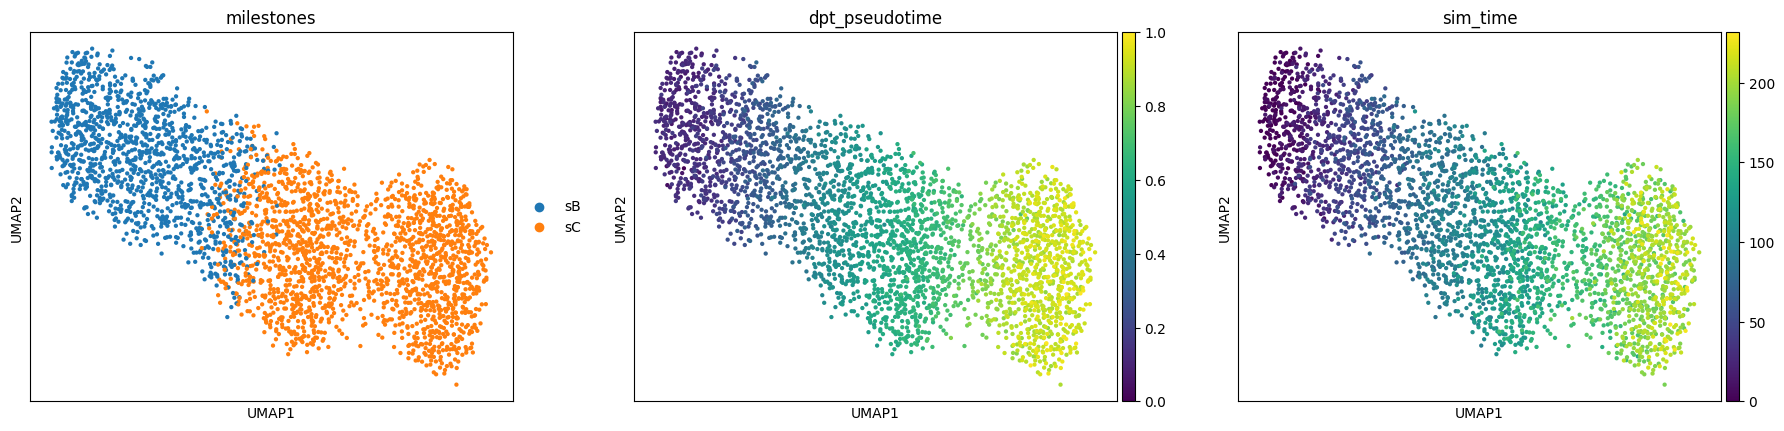

In [13]:
sc.pl.umap(d1, color=["milestones", "dpt_pseudotime", "sim_time"])
sc.pl.umap(d2, color=["milestones", "dpt_pseudotime", "sim_time"])

In [ ]:
# trans = umap.UMAP().fit(d1.obsm['X_pca'][:, :], a = 0.583, b=1.334, min_dist=0.5, spread=1.0, n_components=2, maxiter=None, alpha=1.0, gamma=1.0, negative_sample_rate=5, init_pos='spectral', n_neighbors=15)
# plt.scatter(trans.embedding_[:, 0], trans.embedding_[:,1], c = d1.obs["sim_time"])
# plt.show()

NameError: name 'umap' is not defined

In [ ]:
# def plot_pseudocells(cells, pseudocells, color_cells = "#1b2944", color_pseudocells = "#3abbba"):
#     plt.style.use('seaborn-white')
#     plt.figure()
#     sns.kdeplot(cells, color = color_cells)
#     for pc in pseudocells:
#         plt.axvline(pc, 0, 1, color = color_pseudocells)
#     sns.kdeplot(cells, color = color_cells)
#     plt.savefig(f"pscells_density.svg")
#     # savefig(plt.gcf())
#     plt.style.use('default')

In [11]:
def plot_iroot(data):
    colormap_iroot = np.array(["#C0C0C0"] * data.n_obs)
    colormap_iroot[data.uns["iroot"]] = "#FF0000"

    plt.scatter(
        data.obsm["X_umap"][:, 0],
        data.obsm["X_umap"][:, 1],
        c=colormap_iroot,
        s=10,
        alpha=0.1,
    )

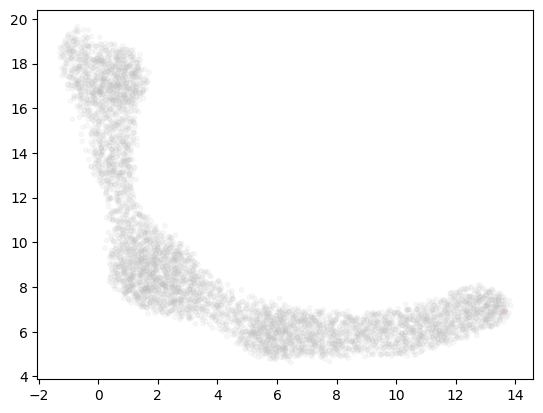

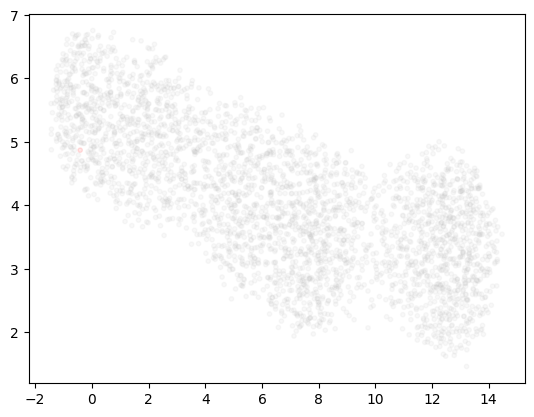

In [ ]:
plot_iroot(d1)
plt.show()
plot_iroot(d2)

# 2. Generate pseudocells

In [62]:
# Generate pseudocells
def calculate_pseudocells(adata, amount: int):
    trunc_anndata = adata
    pseudocell_pseudotimes = interpolate_pseudocells(trunc_anndata, amount)
    trunc_anndata, pseudocells = smooth_pseudocells(trunc_anndata, pseudocell_pseudotimes, amount)

    pseudocell_names = [f"pseudocell_{i}" for i in range(amount)]
    pseudocell_pseudotimes = {k: v for k, v in zip(pseudocell_names, pseudocell_pseudotimes)}

    # Save information into anndata
    adata.varm[f"pseudocells_{amount}"] = pseudocells.T
    adata.uns[f"pseudocells_{amount}_pseudotime"] = pd.Series(pseudocell_pseudotimes)
    if "pseudocells" not in adata.uns:
        adata.uns["pseudocells"] = []
    adata.uns["pseudocells"] += [f"pseudocells_{amount}"]
    return adata

def calc_pc(adata, amount, obsm_key=None):
    interpolated = interpolate_uniform(adata, amount)
    adata, pseudocells, transition_matrix = smooth_pseudocells(adata, interpolated, amount, obsm_key)
    pseudocell_names = [f"pseudocell_{i}" for i in range(amount)]
    pseudocell_pseudotimes = {k: v for k, v in zip(pseudocell_names, interpolated)}

    return adata, pseudocells, pseudocell_pseudotimes, transition_matrix


def interpolate_pseudocells(adata, amount: int):
    # interpolate pseudotime based on the distribution of real cells in the pseudotime
    return np.percentile(sorted(adata.obs.pseudotime.values), np.linspace(0.0, 100, amount))

def interpolate_uniform(adata, amount: int):
    # interpolate pseudotime uniformly
    min_pseudotime = adata.obs.pseudotime.min()
    max_pseudotime = adata.obs.pseudotime.max()
    return np.linspace(min_pseudotime, max_pseudotime, amount)


def smooth_pseudocells(adata, pseudocell_pseudotimes, amount: int, obsm_key=None) -> np.ndarray:
    distances = calculate_pseudotime_distance(pseudocell_pseudotimes, sorted(adata.obs.pseudotime.values))
    adata.uns[f"transition_matrix_{amount}"] = np.array(
        [get_gaussian_transition_matrix(distances[i,], adata.X) for i in range(distances.shape[0])]
    )
    features = adata.X
    if obsm_key is not None:
        features = adata.obsm[obsm_key]
    return adata, np.array([apply_gaussian_kernel(distances[i,], features) for i in range(distances.shape[0])]), adata.uns[f"transition_matrix_{amount}"]

def calculate_pseudotime_distance(pseudocell_pseudotimes, trajectory_pseudotime: np.ndarray) -> np.ndarray:
    distances = []
    for cell in pseudocell_pseudotimes:
        distance = trajectory_pseudotime - cell
        distances.append(distance)
    return np.array(distances)

def apply_gaussian_kernel(x, counts):
    d = get_gaussian_transition_matrix(x, counts)
    
    # d = np.exp(-1 * (x**2) / (2**2))

    # FOR VISUALISATION PURPOSES
    # import matplotlib.pyplot as plt

    # plt.plot(x, color = "red")
    # plt.plot(d, color = "blue")
    # plt.figure()
    # plt.show()

    # d = d / sum(d)
    # plt.plot(d, color = "green")

    # plt.show()

    # @ = matrix multiplication (is transposition necessary or could the arguments be switched?)
    return counts.T @ d


def get_gaussian_transition_matrix(x, counts):
    d = np.exp(-1 * (x**2) / (0.0075**2))
    return d / sum(d)


In [15]:
d1.obs["pseudotime"] = d1.obs["dpt_pseudotime"]
d2.obs["pseudotime"] = d2.obs["dpt_pseudotime"]

In [63]:
d1_, pseudocells1, pseudocell_pseudotimes1, d1_trans = calc_pc(d1, 100)
d2_, pseudocells2, pseudocell_pseudotimes2, d2_trans = calc_pc(d2, 100)

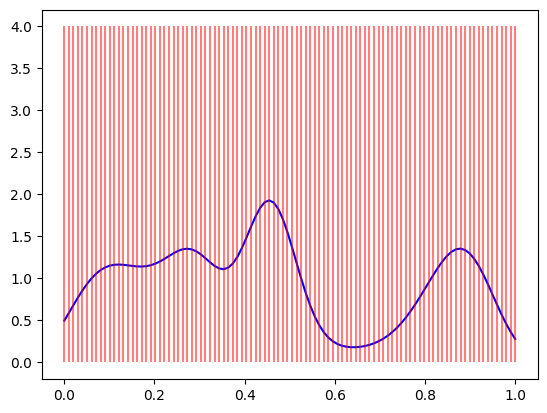

In [64]:
pseudotimes_kde_orig = sp.stats.gaussian_kde(d1.obs["pseudotime"])
x_values = np.linspace(0, 1, 100)
y_values = pseudotimes_kde_orig(x_values)
plt.plot(x_values, y_values, color = "blue")
plt.vlines(pseudocell_pseudotimes1.values(), 0, 4, color = "red", alpha=0.5)

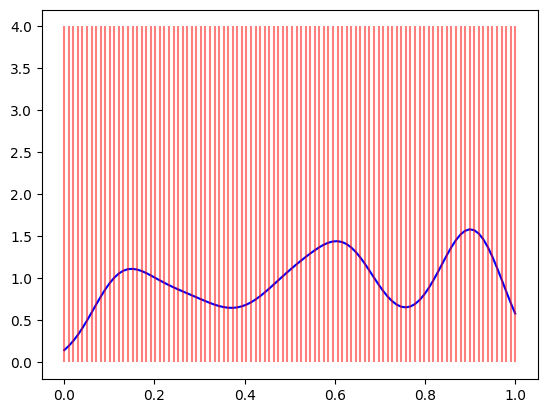

In [65]:
pseudotimes_kde_orig2 = sp.stats.gaussian_kde(d2.obs["pseudotime"])
x_values = np.linspace(0, 1, 100)
y_values = pseudotimes_kde_orig2(x_values)
plt.plot(x_values, y_values, color = "blue")
plt.vlines(pseudocell_pseudotimes2.values(), 0, 4, color = "red", alpha=0.5)

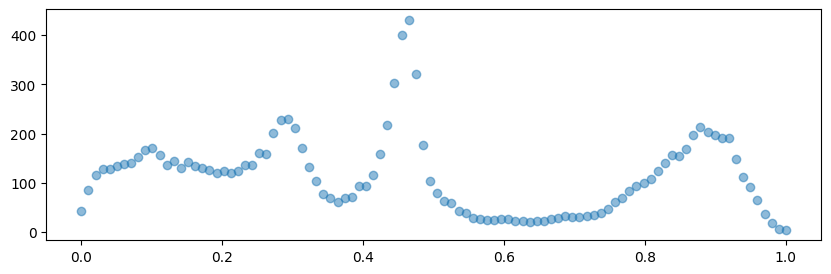

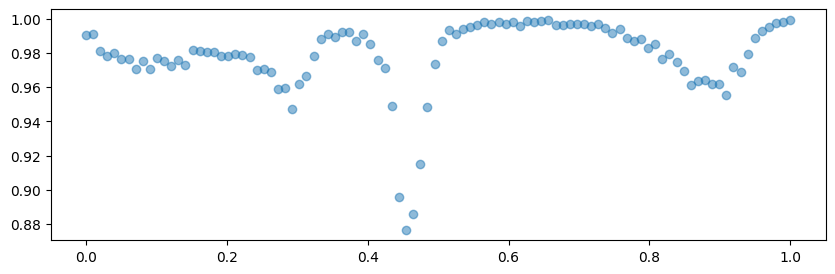

In [70]:
# get all contributions
threshold = 0.001
contributions = []
contributing_cells = []
for i in range(d1_trans.shape[0]):
    contributing_cells_part = d1_trans[i,:] >= threshold
    contributing_cells.append(contributing_cells_part)
    contribution = d1_trans[i,:][d1_trans[i, :] >= threshold]
    contributions.append((sum(contribution), len(contribution)))
    # contributing_cells.extend([i] * len(contribution))

# plot amount covered and number of cells contributing
plt.figure(figsize=(10, 3))
plt.scatter(pseudocell_pseudotimes1.values(), [x[1] for x in contributions], alpha=0.5)
plt.show()
plt.figure(figsize=(10, 3))
plt.scatter(pseudocell_pseudotimes1.values(), [x[0] for x in contributions], alpha=0.5)

# 3. Run DTW

In [76]:
d3 = ad.AnnData(X = pseudocells1, var = d1.var, obs = pd.DataFrame({"pseudotime": pseudocell_pseudotimes1}))
d4 = ad.AnnData(X = pseudocells2, var = d2.var, obs = pd.DataFrame({"pseudotime": pseudocell_pseudotimes2}))
d3, d4

(AnnData object with n_obs × n_vars = 100 × 522
     obs: 'pseudotime'
     var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein',
 AnnData object with n_obs × n_vars = 100 × 522
     obs: 'pseudotime'
     var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein')

In [77]:
total_p, cost_p, distances_p = dtw(d3.X, d4.X)
path1_p, path2_p = traceback(distances_p)

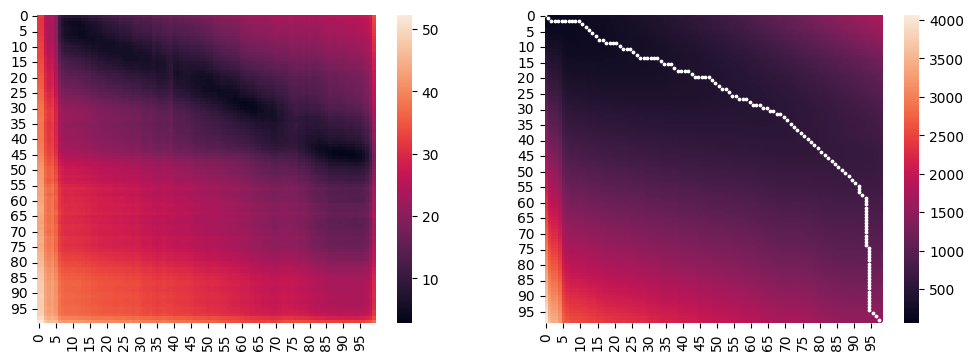

In [78]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
sns.heatmap(cost_p, ax=ax1)
distances_p = distances_p[1:, 1:]
sns.heatmap(distances_p, ax=ax2)
plt.scatter(path2_p, path1_p, c="white", s=3)
plt.show()

In [26]:
d1 = d1[d1.obs["pseudotime"].argsort()]
d2 = d2[d2.obs["pseudotime"].argsort()]
d1.obs.pseudotime, d2.obs.pseudotime

(cell381     0.000000
 cell1918    0.002192
 cell2767    0.002450
 cell5000    0.003452
 cell1948    0.004220
               ...   
 cell3309    0.981333
 cell3589    0.982118
 cell2798    0.986267
 cell2149    0.989258
 cell537     1.000000
 Name: pseudotime, Length: 5000, dtype: float32,
 cell426     0.000000
 cell2871    0.031094
 cell4649    0.033836
 cell2474    0.056709
 cell3551    0.062215
               ...   
 cell4137    0.985255
 cell3170    0.988733
 cell3487    0.992747
 cell3592    0.999858
 cell3704    1.000000
 Name: pseudotime, Length: 3132, dtype: float32)

In [30]:
d1.X = d1.X.todense()
d2.X = d2.X.todense()

/home/louise/Work/dynchro_paper/.venv/lib/python3.13/site-packages/anndata/_core/storage.py:39: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)
/tmp/ipykernel_54886/4293463502.py:1: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  d1.X = d1.X.todense()
/tmp/ipykernel_54886/4293463502.py:2: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  d2.X = d2.X.todense()


In [28]:
total, cost, distances = dtw(d1.X.todense(), d2.X[:, :].todense())
path1, path2 = traceback(distances)

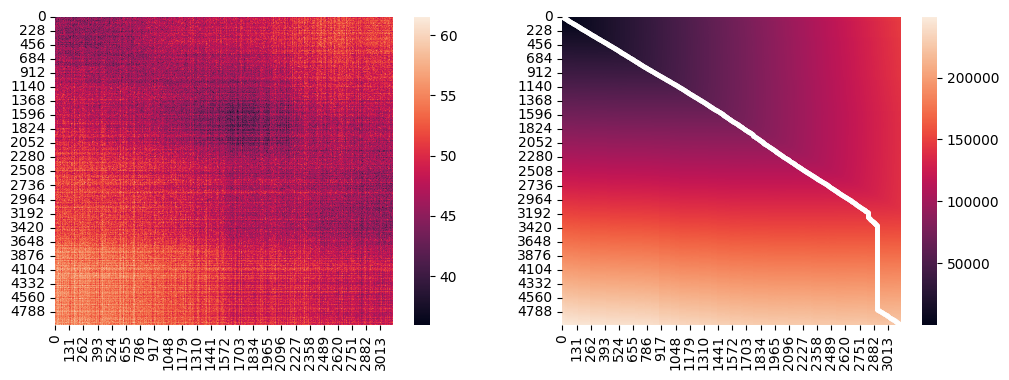

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
sns.heatmap(cost, ax=ax1)
distances = distances[1:, 1:]
sns.heatmap(distances, ax=ax2)
plt.scatter(path2, path1, c="white", s=3)
plt.show()

In [31]:
# pathx must be the path that represents the x values of the path. 
#       it also indexes datasetx, so they must be the same length or less
# pathy must be the path that represents the y values of the path.
#       it also indexes datasety, so they must be the same length or less
def avg_cost_path(pathx, pathy, matrix, datasetx, datasety):
    sorted_names1 = datasetx.obs["pseudotime"].sort_values().index
    sorted_names2 = datasety.obs["pseudotime"].sort_values().index
    print(max(pathx), max(pathy), len(sorted_names1), len(sorted_names2), matrix.shape)

    assert(max(pathx)) <= len(sorted_names1), (f"pathx (max val {max(pathx)}) contains indices that are out of bounds for datasetx (length {len(sorted_names1)})")
    assert(max(pathy)) <=  len(sorted_names2), (f"pathy (max val {max(pathy)}) contains indices that are out of bounds for datasety (length {len(sorted_names2)})")

    # check that at least one of the paths goes to the end of the matrix
    assert(max(pathx) == len(sorted_names1) - 1 or max(pathy) == len(sorted_names2) - 1), f"at least one of the paths must go to the end of the matrix. path x goes to {max(pathx)} and path y goes to {max(pathy)}, but datasetx has {len(sorted_names1)} cells and datasety has {len(sorted_names2)} cells."

    avg_costx = defaultdict(list)
    avg_costy = defaultdict(list)

    for x, y in zip(pathx, pathy):
        # print(x, y)
        cost = matrix[y-1, x-1]

        avg_costx[sorted_names1[x-1]].append(cost)
        avg_costy[sorted_names2[y-1]].append(cost)

    acx = [sum(x) / len(x) for x in avg_costx.values()]
    acy = [sum(x) / len(x) for x in avg_costy.values()]

    costx = pd.Series(acx, index=list(avg_costx.keys()))
    costy = pd.Series(acy, index=list(avg_costy.keys()))

    return costx, costy

In [38]:
def avg_pseudotime_path(pathx, pathy, datasetx, datasety):
    sorted_names1 = datasetx.obs["pseudotime"].sort_values().index
    sorted_names2 = datasety.obs["pseudotime"].sort_values().index

    assert(max(pathx)) <= len(sorted_names1), (f"pathx (max val {max(pathx)}) contains indices that are out of bounds for datasetx (length {len(sorted_names1)})")
    assert(max(pathy)) <=  len(sorted_names2), (f"pathy (max val {max(pathy)}) contains indices that are out of bounds for datasety (length {len(sorted_names2)})")

    # check that at least one of the paths goes to the end of the matrix
    assert(max(pathx) == len(sorted_names1) - 1 or max(pathy) == len(sorted_names2) - 1), f"at least one of the paths must go to the end of the matrix. path x goes to {max(pathx)} and path y goes to {max(pathy)}, but datasetx has {len(sorted_names1)} cells and datasety has {len(sorted_names2)} cells."

    avg_pseudotime1 = defaultdict(list)
    avg_pseudotime2 = defaultdict(list)

    for x, y in zip(pathx, pathy): #path_2p indexes d4, path_1p indexes d3
        ptx = datasetx.obs["pseudotime"].values[x]
        pty = datasety.obs["pseudotime"].values[y]
        print(f"x: {x}, y: {y}, ptx: {ptx}, pty: {pty}")
        avg_pseudotime1[sorted_names1[x]].append(pty)
        avg_pseudotime2[sorted_names2[y]].append(ptx)

    apx = [sum(x) / len(x) for x in avg_pseudotime1.values()]
    apy = [sum(x) / len(x) for x in avg_pseudotime2.values()]
    pseudotime_path1 = pd.Series(apx, index=list(avg_pseudotime1.keys()))
    pseudotime_path2 = pd.Series(apy, index=list(avg_pseudotime2.keys()))

    return pseudotime_path1, pseudotime_path2

In [33]:
costx, costy = avg_cost_path(pathx=path2, pathy=path1, matrix=cost, datasetx=d2, datasety=d1)
distx, disty = avg_cost_path(pathx=path2, pathy=path1, matrix=distances, datasetx=d2, datasety=d1)

d2.obs["avg_cost_free"] = costx
d1.obs["avg_cost_free"] = costy
d2.obs["avg_dist_free"] = distx
d1.obs["avg_dist_free"] = disty

3131 4999 3132 5000 (5000, 3132)
3131 4999 3132 5000 (4999, 3131)


/tmp/ipykernel_54886/4031265418.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  d2.obs["avg_cost_free"] = costx
/tmp/ipykernel_54886/4031265418.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  d1.obs["avg_cost_free"] = costy


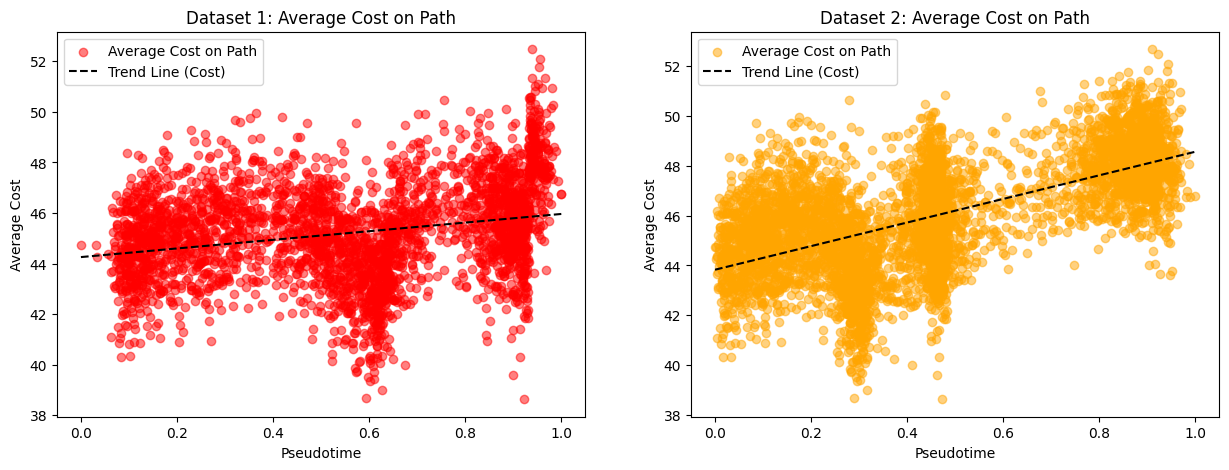

In [34]:
# plt.figure(figsize=(10, 5))
d1_avg_dist = d2.obs.sort_values("pseudotime")["avg_dist_free"].values
d1_avg_cost = d2.obs.sort_values("pseudotime")["avg_cost_free"].values
d2_avg_dist = d1.obs.sort_values("pseudotime")["avg_dist_free"].values
d2_avg_cost = d1.obs.sort_values("pseudotime")["avg_cost_free"].values

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

xvals1 = d2.obs.sort_values("pseudotime")["pseudotime"].values
xvals2 = d1.obs.sort_values("pseudotime")["pseudotime"].values

axes[0].scatter(xvals1, d1_avg_cost, label="Average Cost on Path", color='red', alpha=0.5)
b, a = np.polyfit(xvals1[:-1], d1_avg_cost[:-1], 1)
axes[0].plot(xvals1, b * xvals1 + a, color='black', linestyle='--', label='Trend Line (Cost)')
axes[0].set_title("Dataset 1: Average Cost on Path")
axes[0].set_xlabel("Pseudotime")
axes[0].set_ylabel("Average Cost")
axes[0].legend()

axes[1].scatter(xvals2, d2_avg_cost, label="Average Cost on Path", color='orange', alpha=0.5)
b, a = np.polyfit(xvals2[:-1], d2_avg_cost[:-1], 1)
axes[1].plot(xvals2, b * xvals2 + a, color='black', linestyle='--', label='Trend Line (Cost)')
axes[1].set_title("Dataset 2: Average Cost on Path")
axes[1].set_xlabel("Pseudotime")
axes[1].set_ylabel("Average Cost")
axes[1].legend()

plt.show()  

In [79]:
costx_p, costy_p = avg_cost_path(pathx=path2_p, pathy=path1_p, matrix=cost_p, datasetx=d4, datasety=d3)
distx_p, disty_p = avg_cost_path(pathx=path2_p, pathy=path1_p, matrix=distances_p, datasetx=d4, datasety=d3)

d4.obs["avg_cost_free"] = costx_p
d3.obs["avg_cost_free"] = costy_p
d4.obs["avg_dist_free"] = distx_p
d3.obs["avg_dist_free"] = disty_p

99 99 100 100 (100, 100)
99 99 100 100 (99, 99)


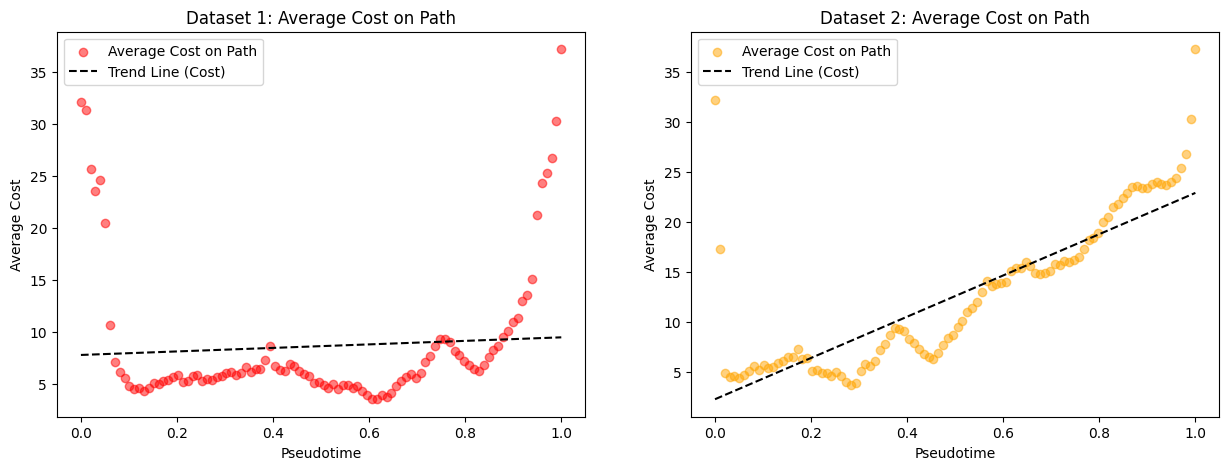

In [80]:
# plt.figure(figsize=(10, 5))
d1_avg_dist = d4.obs.sort_values("pseudotime")["avg_dist_free"].values
d1_avg_cost = d4.obs.sort_values("pseudotime")["avg_cost_free"].values
d2_avg_dist = d3.obs.sort_values("pseudotime")["avg_dist_free"].values
d2_avg_cost = d3.obs.sort_values("pseudotime")["avg_cost_free"].values

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

xvals1 = d4.obs.sort_values("pseudotime")["pseudotime"].values
xvals2 = d3.obs.sort_values("pseudotime")["pseudotime"].values

axes[0].scatter(xvals1, d1_avg_cost, label="Average Cost on Path", color='red', alpha=0.5)
b, a = np.polyfit(xvals1[:-1], d1_avg_cost[:-1], 1)
axes[0].plot(xvals1, b * xvals1 + a, color='black', linestyle='--', label='Trend Line (Cost)')
axes[0].set_title("Dataset 1: Average Cost on Path")
axes[0].set_xlabel("Pseudotime")
axes[0].set_ylabel("Average Cost")
axes[0].legend()

axes[1].scatter(xvals2, d2_avg_cost, label="Average Cost on Path", color='orange', alpha=0.5)
b, a = np.polyfit(xvals2[:-1], d2_avg_cost[:-1], 1)
axes[1].plot(xvals2, b * xvals2 + a, color='black', linestyle='--', label='Trend Line (Cost)')
axes[1].set_title("Dataset 2: Average Cost on Path")
axes[1].set_xlabel("Pseudotime")
axes[1].set_ylabel("Average Cost")
axes[1].legend()

plt.show()  

In [81]:
actual_wpp1, actual_wpp2 = avg_pseudotime_path(pathx=path2, pathy=path1, datasetx=d2, datasety=d1)
d2.obs["pseudotime_warped"] = actual_wpp1
d1.obs["pseudotime_warped"] = actual_wpp2

x: 0, y: 0, ptx: 0.0, pty: 0.0
x: 1, y: 1, ptx: 0.031093550845980644, pty: 0.0021924080792814493
x: 2, y: 2, ptx: 0.033836107701063156, pty: 0.0024504594039171934
x: 3, y: 3, ptx: 0.05670855566859245, pty: 0.0034515252336859703
x: 4, y: 4, ptx: 0.062215011566877365, pty: 0.0042201760224998
x: 5, y: 5, ptx: 0.06260696053504944, pty: 0.0043767159804701805
x: 6, y: 6, ptx: 0.06266194581985474, pty: 0.0048403628170490265
x: 7, y: 7, ptx: 0.06555410474538803, pty: 0.00503764720633626
x: 8, y: 8, ptx: 0.06590553373098373, pty: 0.0052724359557032585
x: 9, y: 9, ptx: 0.06642177700996399, pty: 0.005814895033836365
x: 10, y: 10, ptx: 0.06748795509338379, pty: 0.006005034316331148
x: 11, y: 11, ptx: 0.06905890256166458, pty: 0.006189215928316116
x: 12, y: 12, ptx: 0.06972365826368332, pty: 0.006925681140273809
x: 13, y: 13, ptx: 0.07025758177042007, pty: 0.007093418855220079
x: 14, y: 14, ptx: 0.07128880172967911, pty: 0.007560967933386564
x: 15, y: 15, ptx: 0.07180511951446533, pty: 0.0076036215

In [82]:
wpp1, wpp2 = avg_pseudotime_path(pathx=path2_p, pathy=path1_p, datasetx=d4, datasety=d3)
d4.obs["pseudotime_warped"] = wpp1
d3.obs["pseudotime_warped"] = wpp2

x: 0, y: 0, ptx: 0.0, pty: 0.0
x: 1, y: 1, ptx: 0.010101010091602802, pty: 0.010101010091602802
x: 2, y: 2, ptx: 0.020202020183205605, pty: 0.020202020183205605
x: 3, y: 2, ptx: 0.03030303120613098, pty: 0.020202020183205605
x: 4, y: 2, ptx: 0.04040404036641121, pty: 0.020202020183205605
x: 5, y: 2, ptx: 0.05050504952669144, pty: 0.020202020183205605
x: 6, y: 2, ptx: 0.06060606241226196, pty: 0.020202020183205605
x: 7, y: 2, ptx: 0.07070706784725189, pty: 0.020202020183205605
x: 8, y: 2, ptx: 0.08080808073282242, pty: 0.020202020183205605
x: 9, y: 2, ptx: 0.09090909361839294, pty: 0.020202020183205605
x: 10, y: 2, ptx: 0.10101009905338287, pty: 0.020202020183205605
x: 11, y: 3, ptx: 0.1111111119389534, pty: 0.03030303120613098
x: 12, y: 4, ptx: 0.12121212482452393, pty: 0.04040404036641121
x: 13, y: 5, ptx: 0.13131313025951385, pty: 0.05050504952669144
x: 14, y: 6, ptx: 0.14141413569450378, pty: 0.06060606241226196
x: 15, y: 7, ptx: 0.1515151560306549, pty: 0.07070706784725189
x: 16, y

In [83]:
def map_back(transition_matrix, pseudocell_dataset):
    tresh = 0.001
    mapped_warped_pseudotimes = []
    for i in range(transition_matrix.shape[1]):
        res = transition_matrix[:, i] / sum(transition_matrix[:, i])

        warped_pseudotimes = pseudocell_dataset.obs[res > tresh].pseudotime_warped.values
        contribution_amounts = res[res > tresh]

        result = np.average(warped_pseudotimes, weights=contribution_amounts)
        mapped_warped_pseudotimes.append(result)

    return mapped_warped_pseudotimes

In [84]:
mapped_warped_1 = map_back(transition_matrix=d2_trans, pseudocell_dataset=d4)
mapped_warped_2 = map_back(transition_matrix=d1_trans, pseudocell_dataset=d3)

In [85]:
d2.obs.milestones

cell426     sB
cell2871    sB
cell4649    sB
cell2474    sB
cell3551    sB
            ..
cell4137    sC
cell3170    sC
cell3487    sC
cell3592    sC
cell3704    sC
Name: milestones, Length: 3132, dtype: category
Categories (2, object): ['sB', 'sC']

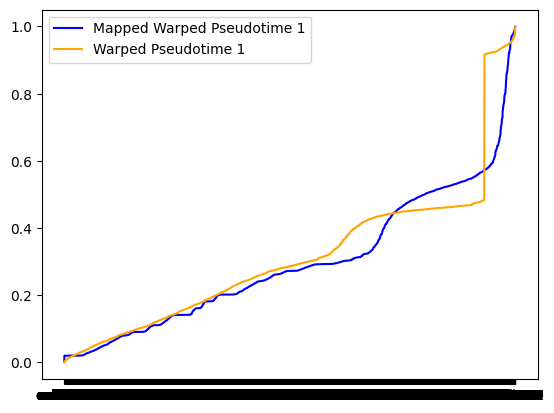

In [86]:
plt.plot(mapped_warped_1, label="Mapped Warped Pseudotime 1", color='blue')
plt.plot(d2.obs["pseudotime_warped"], label="Warped Pseudotime 1", color='orange')
plt.legend()

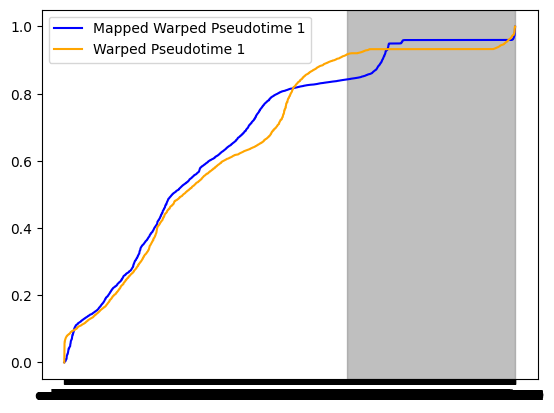

In [87]:
plt.plot(mapped_warped_2, label="Mapped Warped Pseudotime 1", color='blue')
plt.plot(d1.obs["pseudotime_warped"], label="Warped Pseudotime 1", color='orange')

# plot square on x axis from end to end - 1868
plt.axvspan(5000-1868, 5000, color='gray', alpha=0.5)

plt.legend()

In [58]:
len(mapped_warped_2)

5000

In [49]:
import seaborn

In [50]:
import pandas as pd

d1.obs["pseudotime"] = d1.obs["dpt_pseudotime"]
d2_cut.obs["pseudotime"] = d2_cut.obs["dpt_pseudotime"]

d1_pseudocells = calculate_pseudocells(d1, 100)
d2_pseudocells = calculate_pseudocells(d2_cut, 100)
d1, d2_pseudocells

(AnnData object with n_obs × n_vars = 5000 × 522
     obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'pseudotime'
     var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein'
     uns: 'iroot', 'traj_dimred_segments', 'traj_milestone_network', 'traj_progressions', 'milestones_colors', 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'diffmap_evals', 'transition_matrix_100', 'pseudocells_100_pseudotime', 'pseudocells'
     obsm: 'dimred', 'X_pca', 'X_umap', 'X_diffmap'
     varm: 'PCs', 'pseudocells_100'
     layers: 'counts_protein', 'counts_spliced', 'counts_unspliced', 'logcounts'
     obsp: 'distances', 'connectivities',
 AnnData object with n_obs × n_vars = 3132 × 522
     obs: 'step_ix', 'simulation_i', 'si

In [51]:
d1.varm["pseudocells_100"].shape, d2_pseudocells.varm["pseudocells_100"].shape

((522, 100), (522, 100))

In [52]:
d1.X.shape, d2_pseudocells.X.shape

((5000, 522), (3132, 522))

In [53]:
d3 = ad.AnnData(X = d1.varm["pseudocells_100"].T, var = d1.var, obs = pd.DataFrame({"pseudotime": d1.uns["pseudocells_100_pseudotime"]}))
d4 = ad.AnnData(X = d2_pseudocells.varm["pseudocells_100"].T, var = d2_pseudocells.var, obs = pd.DataFrame({"pseudotime": d2_pseudocells.uns["pseudocells_100_pseudotime"]}))
d3, d4

(AnnData object with n_obs × n_vars = 100 × 522
     obs: 'pseudotime'
     var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein',
 AnnData object with n_obs × n_vars = 100 × 522
     obs: 'pseudotime'
     var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein')

In [54]:
d1.var_names

Index(['Burn1_TF1', 'Burn2_TF1', 'Burn3_TF1', 'Burn4_TF1', 'Burn5_TF1',
       'Burn6_TF1', 'A1_TF1', 'A2_TF1', 'A3_TF1', 'A4_TF1',
       ...
       'HK241', 'HK242', 'HK243', 'HK244', 'HK245', 'HK246', 'HK247', 'HK248',
       'HK249', 'HK250'],
      dtype='object', length=522)

In [55]:
all1 = ad.concat([d1, d3], axis=0, label = "type", keys = ["original", "pseudocells"])
all2 = ad.concat([d2_pseudocells, d4], axis=0, label = "type", keys = ["original", "pseudocells"])

In [56]:
all1, all2

(AnnData object with n_obs × n_vars = 5100 × 522
     obs: 'pseudotime', 'type',
 AnnData object with n_obs × n_vars = 3232 × 522
     obs: 'pseudotime', 'type')

In [57]:
sc.pp.neighbors(all1)
sc.tl.umap(all1)


/home/louise/Work/dynchro_paper/.venv/lib/python3.13/site-packages/scanpy/neighbors/__init__.py:586: UserWarning: You’re trying to run this on 522 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  X = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)


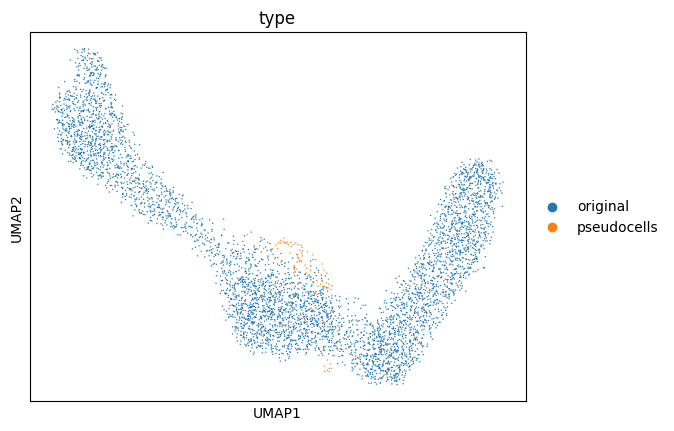

In [58]:
sc.pl.umap(all1, color = ["type"], size = 4)

/home/louise/Work/dynchro_paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


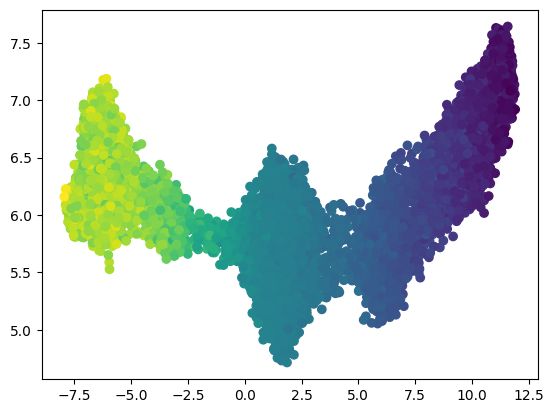

In [59]:
import umap

trans = umap.UMAP().fit(d1.obsm['X_pca'][:, :])
plt.scatter(trans.embedding_[:, 0], trans.embedding_[:,1], c = d1.obs["pseudotime"])
plt.show()
# plt.savefig(f"clustering_{title}.svg")

# embedding = reducer.fit_transform(all1.X, min_dist=0.5, spread=1.0, alpha=1.0, gamma=1.0, negative_sample_rate=5.0, init_pos="spectral")

/home/louise/Work/dynchro_paper/.venv/lib/python3.13/site-packages/scanpy/neighbors/__init__.py:586: UserWarning: You’re trying to run this on 522 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  X = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)
/home/louise/Work/dynchro_paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


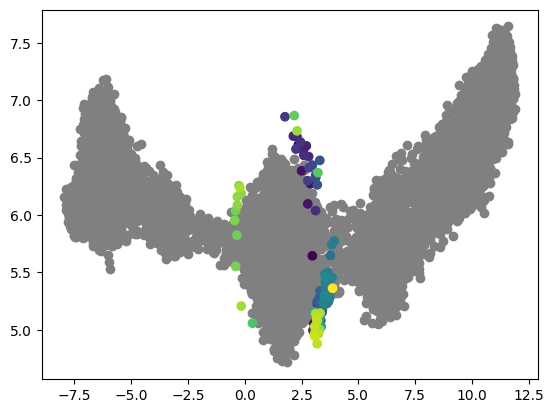

In [60]:
plt.scatter(trans.embedding_[:, 0], trans.embedding_[:,1], c ="grey")

sc.pp.neighbors(d3, random_state=1)
sc.tl.pca(d3)

test_emb = trans.transform(d3.obsm['X_pca'][:,:])
plt.scatter(test_emb[:, 0], test_emb[:,1], c = d3.obs["pseudotime"])

In [ ]:
def plot_umap_pseudocells_warping(adata, adata_pc, title):

    # colors = ["#1b2944", "#ff681c", "#3abbba", "#BCE784", "#E0A500", "#A21515"]
    # colors2 = ["#344F83", "#FF925C", "#73D4D4", "#E3F5CC", "#FFC933", "#E32626"]
    sc.pp.neighbors(adata, random_state=1)
    sc.tl.pca(adata)
    sc.tl.paga(adata, groups = "groups")

    plt.style.use('seaborn-poster')

    plt.figure()
    plt.axis('off')
    trans = umap.UMAP().fit(adata.obsm['X_pca'][:, :])

    plt.scatter(trans.embedding_[:, 0], trans.embedding_[:,1])
    plt.savefig(f"clustering_{title}.svg")
    savefig(plt.gcf())
    plt.figure()
    plt.axis('off')
    ax = plt.gca()
    axes = sc.pl.paga(adata, show = False, ax = ax, node_size_scale=10)
    plt.savefig(f"paga_{title}.svg")
    savefig(ax.figure)

    plt.figure()
    plt.scatter(trans.embedding_[:, 0], trans.embedding_[:,1], c = adata.obs["pseudotime"])
    plt.axis('off')
    plt.savefig(f"dpt_{title}.svg")
    savefig(plt.gcf())


    plt.figure()
    plt.scatter(trans.embedding_[:, 0], trans.embedding_[:,1], c ="grey")

    sc.pp.neighbors(adata_pc, random_state=1)
    sc.tl.pca(adata_pc)

    test_emb = trans.transform(adata_pc.obsm['X_pca'][:,:])
    plt.scatter(test_emb[:, 0], test_emb[:,1], c = adata_pc.obs["pseudotime"])
    plt.axis('off')
    plt.savefig(f"pseudo_umap_{title}.svg")
    savefig(plt.gcf())

    plt.figure()

    plt.scatter(trans.embedding_[:, 0], trans.embedding_[:,1], c = adata.obs["pt_warped"])
    plt.axis('off')
    plt.savefig(f"warped_{title}.svg")
    savefig(plt.gcf())

    plt.figure()

    colors = mpl.colors.ListedColormap(["#1b2944", "#ff681c", "#3abbba", "#BCE784", "#E0A500", "#A21515"])
    colors2 = ["#344F83", "#FF925C", "#73D4D4", "#E3F5CC", "#FFC933", "#E32626"]

    ax, fig = joyplot(
        data=adata.obs,
        by="groups",
        column=["pseudotime", "pt_warped"],
        color = ["#1b2944", "#3abbba"],
        legend=True,
        ylim="own"
    )
    plt.savefig(f"ridge_{title}.svg")
    savefig(plt.gcf())

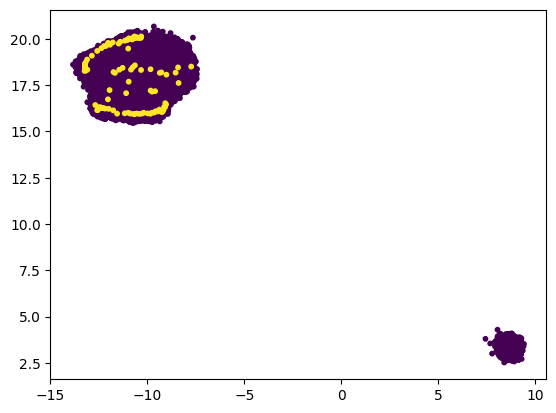

In [158]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=all1.obs["type"].cat.codes, s=10)